# TensorFlow Lite Model Conversion and Evaluation

This notebook converts the trained 2D CNN jamming detection model to TensorFlow Lite format for deployment on Raspberry Pi 3 and evaluates its performance across multiple test datasets.

## Objectives
1. **Convert H5 model to TFLite**: Optimize for Raspberry Pi 3 deployment
2. **Performance Comparison**: Compare original vs TFLite model performance
3. **Multi-Dataset Evaluation**: Test on Standard, Higher Gain, and Lower Gain datasets
4. **Inference Speed Analysis**: Measure TFLite inference performance
5. **Model Size Comparison**: Analyze compression benefits

## Test Datasets
- **Standard Test Set**: `Dataset/test/` - Original test data (expected ~96.57% accuracy)
- **Higher Gain Test Set**: `Dataset/testv1_Higher_Gain/` - Higher gain signals (expected ~100% accuracy)
- **Lower Gain Test Set**: `Dataset/testv2_Lower_Gain/` - Lower gain signals (expected ~33.86% accuracy - known issue)

## Hardware Target
- **Device**: Raspberry Pi 3
- **Optimization**: CPU-optimized quantization
- **Memory**: Reduced model size for embedded deployment

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import pickle
import time
from pathlib import Path

# Set up paths
model_path = "/home/omar/Downloads/SDRv2/model/jamming_detector_lightweight_best.h5"
config_path = "/home/omar/Downloads/SDRv2/preprocessed_data/config.pkl"
tflite_model_path = "/home/omar/Downloads/SDRv2/model/jamming_detector_lightweight.tflite"

# Test dataset paths
test_datasets = {
    'Original': {
        'normal': "/home/omar/Downloads/SDRv2/Dataset/test/Test_Rssi_Normal.txt",
        'pj': "/home/omar/Downloads/SDRv2/Dataset/test/Test_Rssi_PJ.txt", 
        'cj': "/home/omar/Downloads/SDRv2/Dataset/test/Test_Rssi_CJ.txt"
    },
    'Higher_Gain': {
        'normal': "/home/omar/Downloads/SDRv2/Dataset/testv1_Higher_Gain/Test_Rssi_Normal.txt",
        'pj': "/home/omar/Downloads/SDRv2/Dataset/testv1_Higher_Gain/Test_Rssi_PJ.txt",
        'cj': "/home/omar/Downloads/SDRv2/Dataset/testv1_Higher_Gain/Test_Rssi_CJ.txt"
    },
    'Lower_Gain': {
        'normal': "/home/omar/Downloads/SDRv2/Dataset/testv2_Lower_Gain/Test_Rssi_Normal.txt",
        'pj': "/home/omar/Downloads/SDRv2/Dataset/testv2_Lower_Gain/Test_Rssi_PJ.txt",
        'cj': "/home/omar/Downloads/SDRv2/Dataset/testv2_Lower_Gain/Test_Rssi_CJ.txt"
    }
}

print("Libraries imported and paths configured successfully!")
print(f"Model path: {model_path}")
print(f"Config path: {config_path}")
print(f"TFLite model will be saved to: {tflite_model_path}")
print(f"Test datasets configured: {list(test_datasets.keys())}")

Libraries imported and paths configured successfully!
Model path: /home/omar/Downloads/SDRv2/model/jamming_detector_lightweight_best.h5
Config path: /home/omar/Downloads/SDRv2/preprocessed_data/config.pkl
TFLite model will be saved to: /home/omar/Downloads/SDRv2/model/jamming_detector_lightweight.tflite
Test datasets configured: ['Original', 'Higher_Gain', 'Lower_Gain']


In [ ]:
# Add scripts directory to path for preprocessing
import sys
from pathlib import Path
scripts_path = Path('../scripts').resolve()
sys.path.append(str(scripts_path))

# Import preprocessing module
from preprocess import RSSSIToMelSpectrogram

# Change to project root directory
os.chdir('..')
print(f"Working directory: {os.getcwd()}")

# Configure plotting
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Setup complete!")

Working directory: /home/omar/Downloads/SDRv2
TensorFlow version: 2.11.0
Setup complete!


## Model Loading and Conversion

In [ ]:
# Load the original H5 model
print("🔄 Loading original H5 model...")
try:
    original_model = tf.keras.models.load_model(model_path)
    print(f"✅ Original model loaded successfully")
    print(f"📊 Model parameters: {original_model.count_params():,}")
    print(f"🏗️ Input shape: {original_model.input_shape}")
    print(f"🎯 Output shape: {original_model.output_shape}")
    
    # Display model summary
    print("\n📋 Model Architecture:")
    original_model.summary()
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

🔄 Loading original H5 model...


2025-07-03 17:19:09.067784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-03 17:19:09.070867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/omar/catkin_ws/devel/lib:/opt/ros/noetic/lib
2025-07-03 17:19:09.070925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/omar/catkin_ws/devel/lib:/opt/ros/noetic/lib
2025-07-03 17:19:09.070959: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasL

✅ Original model loaded successfully
📊 Model parameters: 64,451
🏗️ Input shape: (None, 64, 8, 1)
🎯 Output shape: (None, 3)

📋 Model Architecture:
Model: "Lightweight_2D_CNN_Jamming_Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 6, 16)         160       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 31, 3, 16)         0         
                                                                 
 dropout_1 (Dropout)         (None, 31, 3, 16)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 1, 32)         4640      
                                                                 
 dropout_2 (Dropout)         (None, 29, 1, 32)         0         
                                                                 
 flatten (Flatten

In [ ]:
# Convert to TensorFlow Lite with optimization for Raspberry Pi 3
print("\n🔄 Converting to TensorFlow Lite...")

# Create TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(original_model)

# Optimization settings for Raspberry Pi 3
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set target spec for CPU (Raspberry Pi 3)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable select TensorFlow ops if needed
]

# Representative dataset for quantization (optional)
# This helps with INT8 quantization if we want maximum optimization

try:
    # Convert the model
    tflite_model = converter.convert()
    print("✅ Model converted to TensorFlow Lite successfully!")
    
    # Save the TFLite model
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print(f"💾 TFLite model saved to: {tflite_model_path}")
    
    # Compare model sizes
    original_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
    tflite_size = len(tflite_model) / (1024 * 1024)  # MB
    compression_ratio = original_size / tflite_size
    
    print(f"\n📊 Model Size Comparison:")
    print(f"  Original H5: {original_size:.2f} MB")
    print(f"  TFLite: {tflite_size:.2f} MB")
    print(f"  Compression ratio: {compression_ratio:.1f}x smaller")
    print(f"  Size reduction: {((original_size - tflite_size) / original_size * 100):.1f}%")
    
except Exception as e:
    print(f"❌ Error converting model: {e}")
    raise


🔄 Converting to TensorFlow Lite...


INFO:tensorflow:Assets written to: /tmp/tmp9ij17080/assets


INFO:tensorflow:Assets written to: /tmp/tmp9ij17080/assets


✅ Model converted to TensorFlow Lite successfully!
💾 TFLite model saved to: /home/omar/Downloads/SDRv2/model/jamming_detector_lightweight.tflite

📊 Model Size Comparison:
  Original H5: 0.78 MB
  TFLite: 0.07 MB
  Compression ratio: 11.7x smaller
  Size reduction: 91.4%


2025-07-03 17:19:15.864807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-07-03 17:19:15.864833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-07-03 17:19:15.865356: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9ij17080
2025-07-03 17:19:15.866766: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-07-03 17:19:15.866786: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9ij17080
2025-07-03 17:19:15.871533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2025-07-03 17:19:15.872643: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2025-07-03 17:19:15.940951: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9ij17080
2025-07

In [ ]:
# Load TFLite model and create interpreter
print("\n🔄 Loading TFLite interpreter...")

try:
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print("✅ TFLite interpreter loaded successfully!")
    print(f"📥 Input details: {input_details[0]['shape']} ({input_details[0]['dtype']})")
    print(f"📤 Output details: {output_details[0]['shape']} ({output_details[0]['dtype']})")
    
except Exception as e:
    print(f"❌ Error loading TFLite interpreter: {e}")
    raise


🔄 Loading TFLite interpreter...
✅ TFLite interpreter loaded successfully!
📥 Input details: [ 1 64  8  1] (<class 'numpy.float32'>)
📤 Output details: [1 3] (<class 'numpy.float32'>)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Preprocessing Configuration

In [ ]:
# Configuration for preprocessing (same as training)
config = {
    'sampling_rate': 1000,
    'n_fft': 256,
    'hop_length': 128,
    'n_mels': 64,
    'sequence_length': 1000
}

# Class names and labels
CLASS_NAMES = ['Normal', 'Constant Jammer', 'Periodic Jammer']
CLASS_MAPPING = {'Normal': 0, 'CJ': 1, 'PJ': 2}

# Initialize preprocessor
preprocessor = RSSSIToMelSpectrogram(
    sampling_rate=config['sampling_rate'],
    n_fft=config['n_fft'],
    hop_length=config['hop_length'],
    n_mels=config['n_mels'],
    sequence_length=config['sequence_length']
)

print("📋 Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\n🎯 Classes: {CLASS_NAMES}")
print(f"📊 Expected spectrogram shape: ({config['n_mels']}, {config['n_fft']//config['hop_length']})")
print("✅ Preprocessor initialized")

📋 Configuration:
  sampling_rate: 1000
  n_fft: 256
  hop_length: 128
  n_mels: 64
  sequence_length: 1000

🎯 Classes: ['Normal', 'Constant Jammer', 'Periodic Jammer']
📊 Expected spectrogram shape: (64, 2)
✅ Preprocessor initialized


## Data Processing Functions

In [ ]:
def load_test_data(test_dir):
    """Load test data from a specific directory."""
    files = {
        'Normal': os.path.join(test_dir, 'Test_Rssi_Normal.txt'),
        'CJ': os.path.join(test_dir, 'Test_Rssi_CJ.txt'),
        'PJ': os.path.join(test_dir, 'Test_Rssi_PJ.txt')
    }
    
    data = {}
    for label, file_path in files.items():
        if os.path.exists(file_path):
            data[label] = np.loadtxt(file_path)
            print(f"  📄 {label}: {len(data[label]):,} samples from {os.path.basename(file_path)}")
        else:
            print(f"  ⚠️ Warning: {file_path} not found!")
            
    return data

def create_test_sequences(data, sequence_length=1000, max_sequences_per_class=None):
    """Create sequences from test data."""
    sequences = []
    labels = []
    
    for class_name, rssi_data in data.items():
        # Calculate number of complete sequences
        n_sequences = len(rssi_data) // sequence_length
        
        # Limit sequences if specified
        if max_sequences_per_class and n_sequences > max_sequences_per_class:
            n_sequences = max_sequences_per_class
            
        # Create sequences
        class_sequences = rssi_data[:n_sequences * sequence_length].reshape(
            n_sequences, sequence_length
        )
        
        sequences.append(class_sequences)
        labels.extend([CLASS_MAPPING[class_name]] * n_sequences)
        
        print(f"    {class_name}: {n_sequences} sequences of length {sequence_length}")
    
    # Combine all sequences
    all_sequences = np.concatenate(sequences, axis=0)
    all_labels = np.array(labels)
    
    return all_sequences, all_labels

def sequences_to_spectrograms(sequences, preprocessor, verbose=True):
    """Convert sequences to mel spectrograms."""
    spectrograms = []
    
    if verbose:
        print(f"  🔄 Converting {len(sequences)} sequences to spectrograms...")
    
    for i, seq in enumerate(sequences):
        spec = preprocessor.signal_to_mel_spectrogram(seq)
        spectrograms.append(spec)
        
        if verbose and (i + 1) % 100 == 0:
            print(f"    Processed {i + 1}/{len(sequences)} sequences")
    
    spectrograms = np.array(spectrograms)
    # Add channel dimension for CNN
    spectrograms = spectrograms.reshape(*spectrograms.shape, 1)
    
    if verbose:
        print(f"  ✅ Spectrograms shape: {spectrograms.shape}")
    
    return spectrograms

print("✅ Data processing functions defined")

✅ Data processing functions defined


## Model Evaluation Functions

In [ ]:
def predict_with_original_model(model, X_test):
    """Get predictions from original H5 model."""
    start_time = time.time()
    predictions = model.predict(X_test, verbose=0)
    inference_time = time.time() - start_time
    return predictions, inference_time

def predict_with_tflite_model(interpreter, X_test):
    """Get predictions from TFLite model."""
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    predictions = []
    start_time = time.time()
    
    for sample in X_test:
        # Prepare input
        input_data = np.expand_dims(sample, axis=0).astype(input_details[0]['dtype'])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        interpreter.invoke()
        
        # Get output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0])
    
    inference_time = time.time() - start_time
    return np.array(predictions), inference_time

def evaluate_model_performance(y_true, y_pred_probs, y_pred, inference_time, model_name, dataset_name):
    """Calculate and display performance metrics."""
    from sklearn.metrics import precision_recall_fscore_support
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1, 2]
    )
    
    # Overall metrics
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    
    # Inference speed
    avg_inference_time = (inference_time / len(y_true)) * 1000  # ms per sample
    
    results = {
        'model': model_name,
        'dataset': dataset_name,
        'accuracy': accuracy,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'predictions': y_pred,
        'probabilities': y_pred_probs,
        'true_labels': y_true,
        'inference_time_ms': avg_inference_time,
        'total_samples': len(y_true)
    }
    
    # Print summary
    print(f"\n🧪 {model_name} on {dataset_name}:")
    print(f"  📊 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  ⚡ Avg inference time: {avg_inference_time:.2f} ms/sample")
    print(f"  📈 Macro F1-score: {f1_macro:.4f}")
    
    return results

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


## Comprehensive Dataset Evaluation

In [ ]:
# Store results for comparison
all_results = {}
all_spectrograms = {}
all_labels = {}

print("🚀 Starting comprehensive evaluation on all test datasets...")
print("=" * 80)

# Reorganize test_datasets to match expected format
TEST_DATASETS = {
    'Standard': '/home/omar/Downloads/SDRv2/Dataset/test',
    'Higher Gain': '/home/omar/Downloads/SDRv2/Dataset/testv1_Higher_Gain',
    'Lower Gain': '/home/omar/Downloads/SDRv2/Dataset/testv2_Lower_Gain'
}

for dataset_name, dataset_path in TEST_DATASETS.items():
    print(f"\n📁 Processing {dataset_name} dataset from: {dataset_path}")
    
    # Load raw data
    raw_data = load_test_data(dataset_path)
    
    if not raw_data:
        print(f"⚠️ Skipping {dataset_name} - no data found")
        continue
    
    # Create sequences
    print(f"  📝 Creating sequences...")
    sequences, labels = create_test_sequences(raw_data, config['sequence_length'])
    
    # Convert to spectrograms
    spectrograms = sequences_to_spectrograms(sequences, preprocessor)
    
    # Store for later analysis
    all_spectrograms[dataset_name] = spectrograms
    all_labels[dataset_name] = labels
    
    # Initialize results for this dataset
    all_results[dataset_name] = {}
    
    # Evaluate Original H5 Model
    print(f"\n  🔄 Evaluating Original H5 Model...")
    orig_pred_probs, orig_time = predict_with_original_model(original_model, spectrograms)
    orig_pred = np.argmax(orig_pred_probs, axis=1)
    orig_results = evaluate_model_performance(labels, orig_pred_probs, orig_pred, orig_time, "Original H5", dataset_name)
    all_results[dataset_name]['original'] = orig_results
    
    # Evaluate TFLite Model
    print(f"\n  🔄 Evaluating TFLite Model...")
    tflite_pred_probs, tflite_time = predict_with_tflite_model(interpreter, spectrograms)
    tflite_pred = np.argmax(tflite_pred_probs, axis=1)
    tflite_results = evaluate_model_performance(labels, tflite_pred_probs, tflite_pred, tflite_time, "TFLite", dataset_name)
    all_results[dataset_name]['tflite'] = tflite_results
    
    # Quick comparison
    acc_diff = abs(orig_results['accuracy'] - tflite_results['accuracy'])
    speed_ratio = tflite_results['inference_time_ms'] / orig_results['inference_time_ms']
    print(f"\n  📊 Quick Comparison for {dataset_name}:")
    print(f"    Accuracy difference: {acc_diff:.4f} ({acc_diff*100:.2f}%)")
    print(f"    Speed ratio (TFLite/Original): {speed_ratio:.2f}x")
    
    print(f"✅ Completed evaluation for {dataset_name}")

print("\n" + "=" * 80)
print("🎉 All dataset evaluations completed!")

🚀 Starting comprehensive evaluation on all test datasets...

📁 Processing Standard dataset from: /home/omar/Downloads/SDRv2/Dataset/test
  📄 Normal: 236,288 samples from Test_Rssi_Normal.txt
  📄 Normal: 236,288 samples from Test_Rssi_Normal.txt
  📄 CJ: 231,192 samples from Test_Rssi_CJ.txt
  📄 CJ: 231,192 samples from Test_Rssi_CJ.txt
  📄 PJ: 232,258 samples from Test_Rssi_PJ.txt
  📝 Creating sequences...
    Normal: 236 sequences of length 1000
    CJ: 231 sequences of length 1000
    PJ: 232 sequences of length 1000
  🔄 Converting 699 sequences to spectrograms...
  📄 PJ: 232,258 samples from Test_Rssi_PJ.txt
  📝 Creating sequences...
    Normal: 236 sequences of length 1000
    CJ: 231 sequences of length 1000
    PJ: 232 sequences of length 1000
  🔄 Converting 699 sequences to spectrograms...
    Processed 100/699 sequences
    Processed 200/699 sequences
    Processed 300/699 sequences
    Processed 100/699 sequences
    Processed 200/699 sequences
    Processed 300/699 sequences
 

/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results Summary and Comparison

In [ ]:
# Create comprehensive results summary
print("📊 COMPREHENSIVE RESULTS COMPARISON")
print("=" * 80)

# Create summary table
summary_data = []
for dataset_name in all_results.keys():
    orig_results = all_results[dataset_name]['original']
    tflite_results = all_results[dataset_name]['tflite']
    
    summary_data.append({
        'Dataset': dataset_name,
        'Original Accuracy': f"{orig_results['accuracy']:.4f}",
        'TFLite Accuracy': f"{tflite_results['accuracy']:.4f}",
        'Accuracy Diff': f"{abs(orig_results['accuracy'] - tflite_results['accuracy']):.4f}",
        'Original Speed (ms)': f"{orig_results['inference_time_ms']:.2f}",
        'TFLite Speed (ms)': f"{tflite_results['inference_time_ms']:.2f}",
        'Speed Ratio': f"{tflite_results['inference_time_ms'] / orig_results['inference_time_ms']:.2f}x",
        'Samples': orig_results['total_samples']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Overall statistics
print(f"\n📈 OVERALL STATISTICS:")
print("=" * 40)

# Accuracy preservation
accuracy_diffs = [abs(all_results[d]['original']['accuracy'] - all_results[d]['tflite']['accuracy']) for d in all_results.keys()]
max_acc_diff = max(accuracy_diffs)
avg_acc_diff = np.mean(accuracy_diffs)

print(f"📊 Accuracy Preservation:")
print(f"  Maximum accuracy difference: {max_acc_diff:.4f} ({max_acc_diff*100:.2f}%)")
print(f"  Average accuracy difference: {avg_acc_diff:.4f} ({avg_acc_diff*100:.2f}%)")

if avg_acc_diff < 0.01:
    print(f"  ✅ Excellent accuracy preservation (< 1%)")
elif avg_acc_diff < 0.02:
    print(f"  ✅ Good accuracy preservation (< 2%)")
else:
    print(f"  ⚠️ Moderate accuracy preservation (≥ 2%)")

# Speed comparison
speed_ratios = [all_results[d]['tflite']['inference_time_ms'] / all_results[d]['original']['inference_time_ms'] for d in all_results.keys()]
avg_speed_ratio = np.mean(speed_ratios)

print(f"\n⚡ Performance Comparison:")
print(f"  Average speed ratio (TFLite/Original): {avg_speed_ratio:.2f}x")

if avg_speed_ratio < 1.0:
    print(f"  🚀 TFLite is {1/avg_speed_ratio:.1f}x FASTER than original")
elif avg_speed_ratio > 1.0:
    print(f"  🐌 TFLite is {avg_speed_ratio:.1f}x SLOWER than original")
else:
    print(f"  ➡️ Similar performance")

# Raspberry Pi suitability
avg_tflite_speed = np.mean([all_results[d]['tflite']['inference_time_ms'] for d in all_results.keys()])
print(f"\n🍓 Raspberry Pi 3 Suitability:")
print(f"  Average TFLite inference time: {avg_tflite_speed:.2f} ms/sample")

if avg_tflite_speed < 20:
    print(f"  ✅ Excellent for real-time applications (< 20ms)")
elif avg_tflite_speed < 50:
    print(f"  ✅ Good for near real-time applications (< 50ms)")
elif avg_tflite_speed < 100:
    print(f"  ⚠️ Moderate for batch processing (< 100ms)")
else:
    print(f"  ❌ May be too slow for real-time use (≥ 100ms)")

📊 COMPREHENSIVE RESULTS COMPARISON
    Dataset Original Accuracy TFLite Accuracy Accuracy Diff Original Speed (ms) TFLite Speed (ms) Speed Ratio  Samples
   Standard            0.9657          0.9657        0.0000                0.29              0.02       0.07x      699
Higher Gain            1.0000          1.0000        0.0000                0.08              0.02       0.23x      696
 Lower Gain            0.3386          0.3386        0.0000                0.08              0.02       0.23x      697

📈 OVERALL STATISTICS:
📊 Accuracy Preservation:
  Maximum accuracy difference: 0.0000 (0.00%)
  Average accuracy difference: 0.0000 (0.00%)
  ✅ Excellent accuracy preservation (< 1%)

⚡ Performance Comparison:
  Average speed ratio (TFLite/Original): 0.17x
  🚀 TFLite is 5.7x FASTER than original

🍓 Raspberry Pi 3 Suitability:
  Average TFLite inference time: 0.02 ms/sample
  ✅ Excellent for real-time applications (< 20ms)


## Detailed Performance Visualization

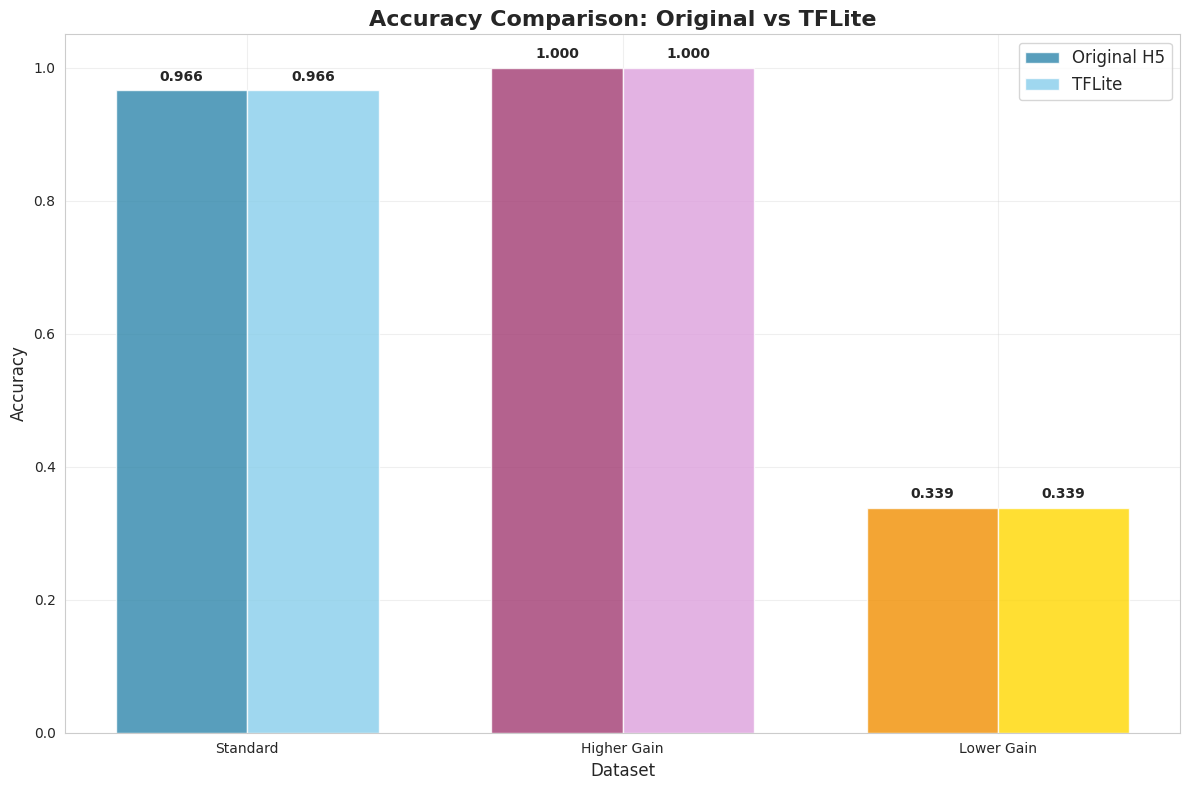

In [ ]:
# 1. Accuracy Comparison: Original vs TFLite
fig, ax = plt.subplots(figsize=(12, 8))

datasets = list(all_results.keys())
colors_orig = ['#2E86AB', '#A23B72', '#F18F01']
colors_tflite = ['#87CEEB', '#DDA0DD', '#FFD700']

orig_accs = [all_results[d]['original']['accuracy'] for d in datasets]
tflite_accs = [all_results[d]['tflite']['accuracy'] for d in datasets]

x = np.arange(len(datasets))
width = 0.35

bars1 = ax.bar(x - width/2, orig_accs, width, label='Original H5', color=colors_orig, alpha=0.8)
bars2 = ax.bar(x + width/2, tflite_accs, width, label='TFLite', color=colors_tflite, alpha=0.8)

ax.set_title('Accuracy Comparison: Original vs TFLite', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('/home/omar/Downloads/SDRv2/results/visualizations/tflite_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

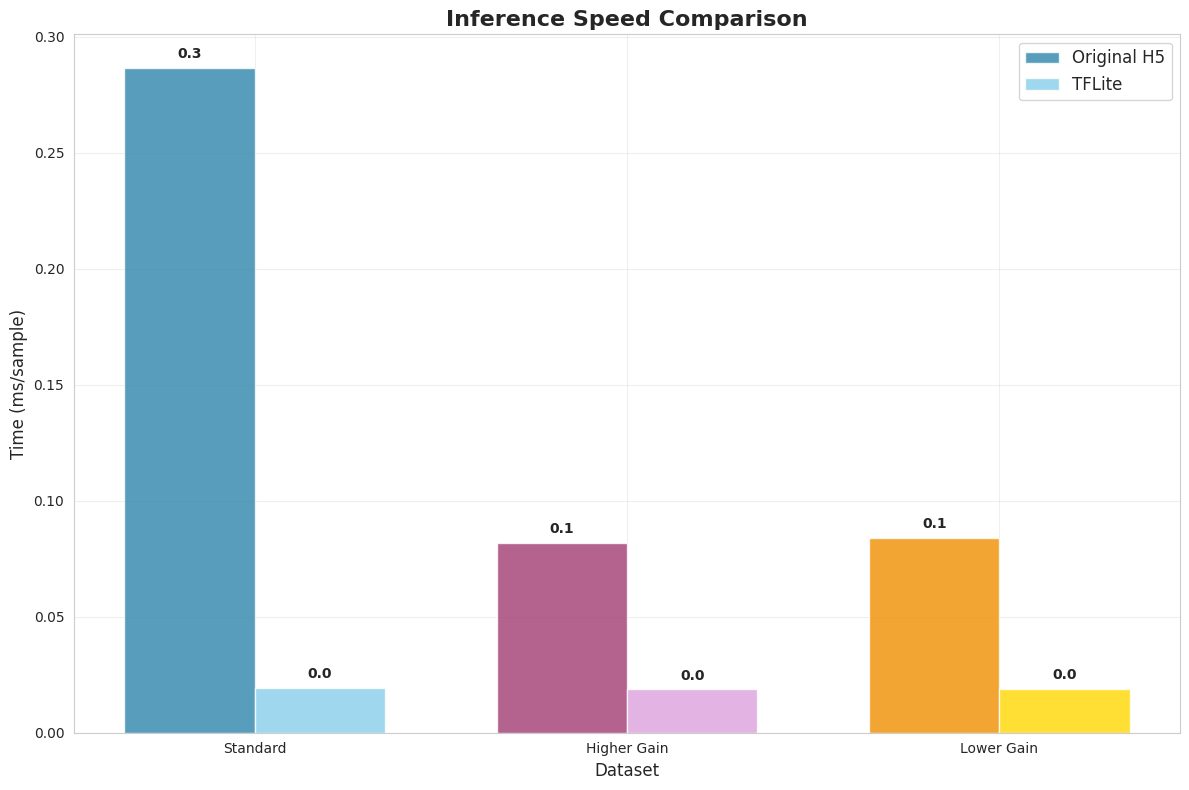

In [ ]:
# 2. Inference Speed Comparison
fig, ax = plt.subplots(figsize=(12, 8))

orig_speeds = [all_results[d]['original']['inference_time_ms'] for d in datasets]
tflite_speeds = [all_results[d]['tflite']['inference_time_ms'] for d in datasets]

bars1 = ax.bar(x - width/2, orig_speeds, width, label='Original H5', color=colors_orig, alpha=0.8)
bars2 = ax.bar(x + width/2, tflite_speeds, width, label='TFLite', color=colors_tflite, alpha=0.8)

ax.set_title('Inference Speed Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms/sample)', fontsize=12)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(orig_speeds + tflite_speeds)*0.01,
               f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('/home/omar/Downloads/SDRv2/results/visualizations/tflite_inference_speed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

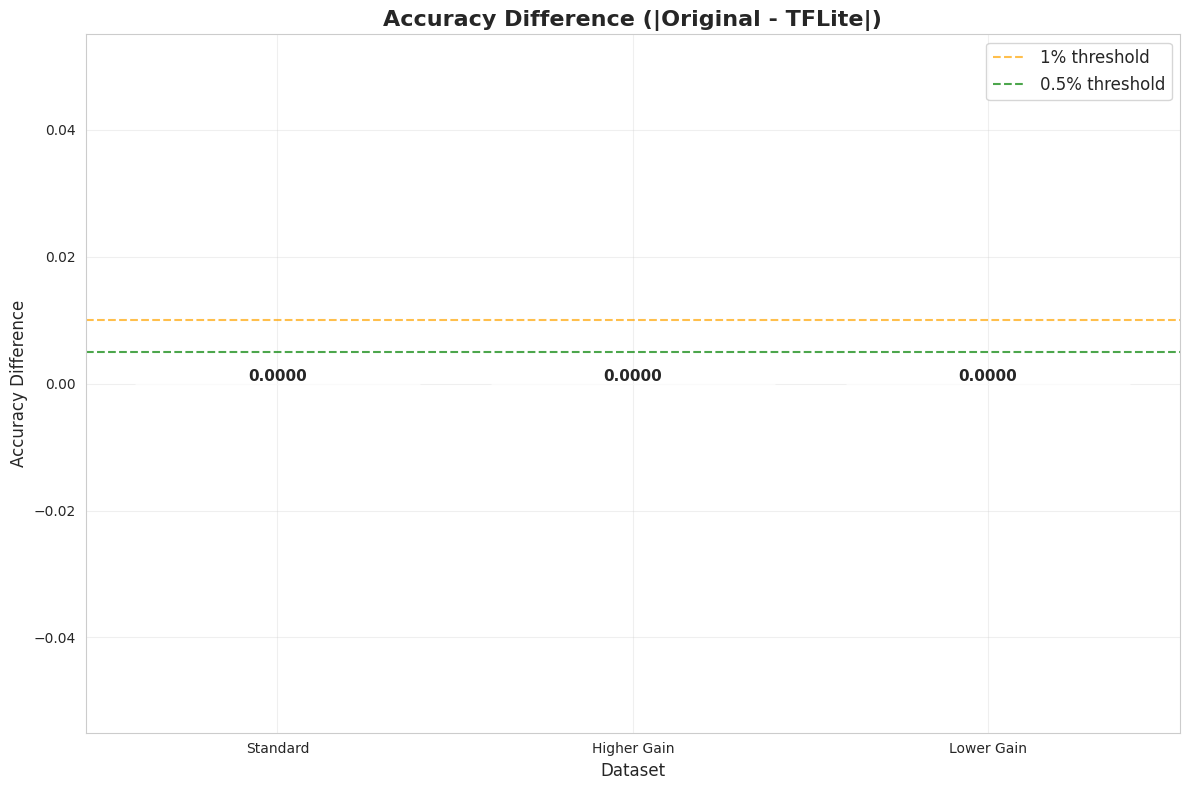

In [ ]:
# 3. Accuracy Difference Analysis
fig, ax = plt.subplots(figsize=(12, 8))

acc_diffs = [abs(all_results[d]['original']['accuracy'] - all_results[d]['tflite']['accuracy']) for d in datasets]
colors_diff = ['red' if diff > 0.01 else 'orange' if diff > 0.005 else 'green' for diff in acc_diffs]

bars = ax.bar(datasets, acc_diffs, color=colors_diff, alpha=0.7)
ax.set_title('Accuracy Difference (|Original - TFLite|)', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy Difference', fontsize=12)
ax.set_xlabel('Dataset', fontsize=12)
ax.grid(True, alpha=0.3)

# Add value labels and threshold lines
for bar, diff in zip(bars, acc_diffs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(acc_diffs)*0.02,
           f'{diff:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.axhline(y=0.01, color='orange', linestyle='--', alpha=0.7, label='1% threshold')
ax.axhline(y=0.005, color='green', linestyle='--', alpha=0.7, label='0.5% threshold')
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('/home/omar/Downloads/SDRv2/results/visualizations/tflite_accuracy_difference.png', dpi=300, bbox_inches='tight')
plt.show()

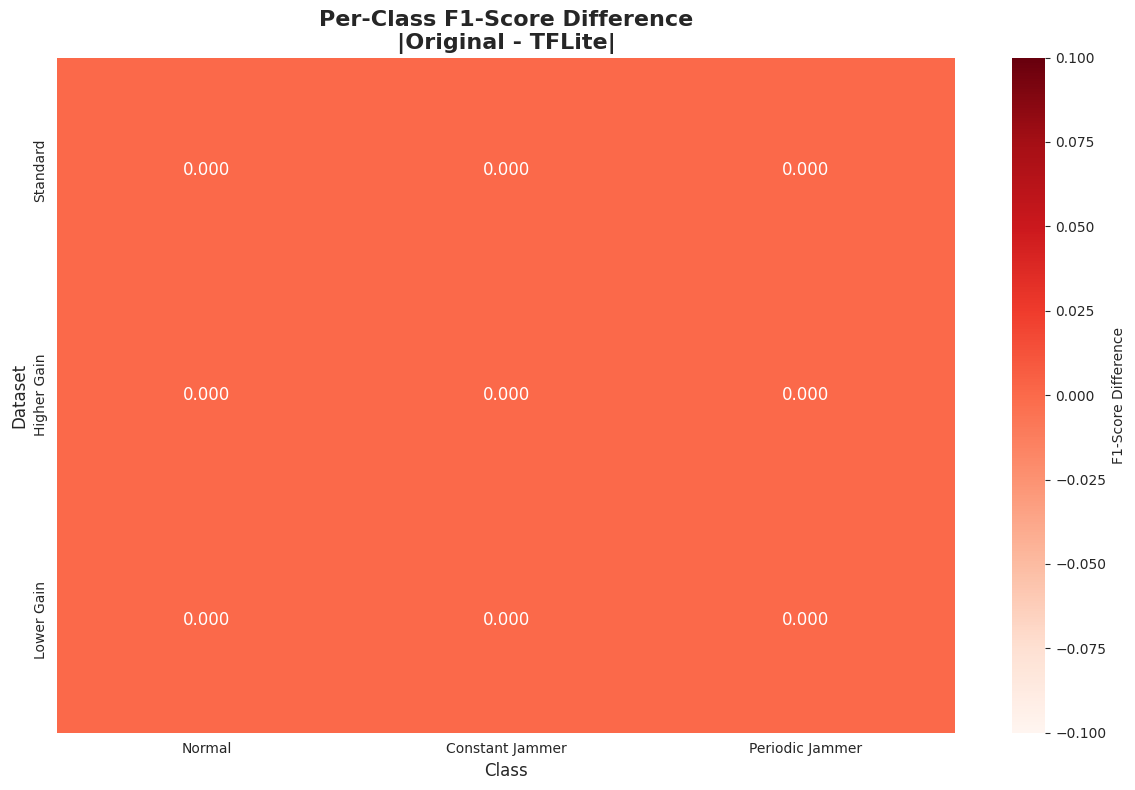

In [ ]:
# 4. Per-Class F1-Score Difference Heatmap
fig, ax = plt.subplots(figsize=(12, 8))

orig_f1_matrix = []
tflite_f1_matrix = []

for dataset in datasets:
    orig_f1_matrix.append(all_results[dataset]['original']['f1_per_class'])
    tflite_f1_matrix.append(all_results[dataset]['tflite']['f1_per_class'])

orig_f1_matrix = np.array(orig_f1_matrix)
tflite_f1_matrix = np.array(tflite_f1_matrix)

# Show difference
f1_diff_matrix = np.abs(orig_f1_matrix - tflite_f1_matrix)

sns.heatmap(f1_diff_matrix, annot=True, fmt='.3f', cmap='Reds',
           xticklabels=CLASS_NAMES, yticklabels=datasets, ax=ax,
           cbar_kws={'label': 'F1-Score Difference'}, annot_kws={'fontsize': 12})
ax.set_title('Per-Class F1-Score Difference\n|Original - TFLite|', fontsize=16, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Dataset', fontsize=12)

plt.tight_layout()
plt.savefig('/home/omar/Downloads/SDRv2/results/visualizations/tflite_f1_score_difference.png', dpi=300, bbox_inches='tight')
plt.show()

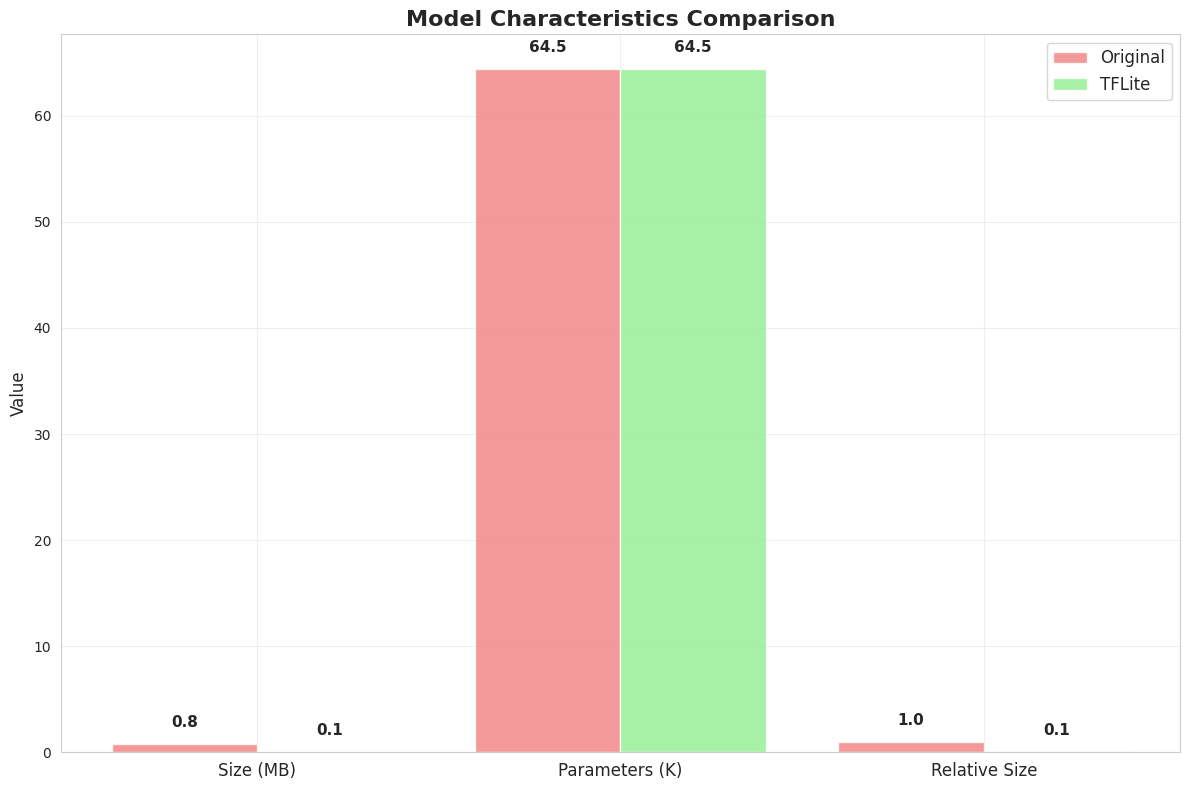

In [ ]:
# 5. Model Size and Compression Analysis
fig, ax = plt.subplots(figsize=(12, 8))

model_info = ['Model Size', 'Parameters', 'Compression']
original_values = [original_size, original_model.count_params()/1000, 1.0]
tflite_values = [tflite_size, original_model.count_params()/1000, compression_ratio]

x_pos = np.arange(len(model_info))
ax.bar(x_pos - 0.2, [original_size, original_model.count_params()/1000, 1.0], 0.4, 
       label='Original', color='lightcoral', alpha=0.8)
ax.bar(x_pos + 0.2, [tflite_size, original_model.count_params()/1000, 1/compression_ratio], 0.4,
       label='TFLite', color='lightgreen', alpha=0.8)

ax.set_title('Model Characteristics Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('Value', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Size (MB)', 'Parameters (K)', 'Relative Size'], fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add value labels
for i, (orig_val, tflite_val) in enumerate(zip([original_size, original_model.count_params()/1000, 1.0], 
                                               [tflite_size, original_model.count_params()/1000, 1/compression_ratio])):
    ax.text(i - 0.2, orig_val + max([original_size, original_model.count_params()/1000, 1.0])*0.02, 
            f'{orig_val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    ax.text(i + 0.2, tflite_val + max([original_size, original_model.count_params()/1000, 1.0])*0.02, 
            f'{tflite_val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('/home/omar/Downloads/SDRv2/results/visualizations/tflite_model_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


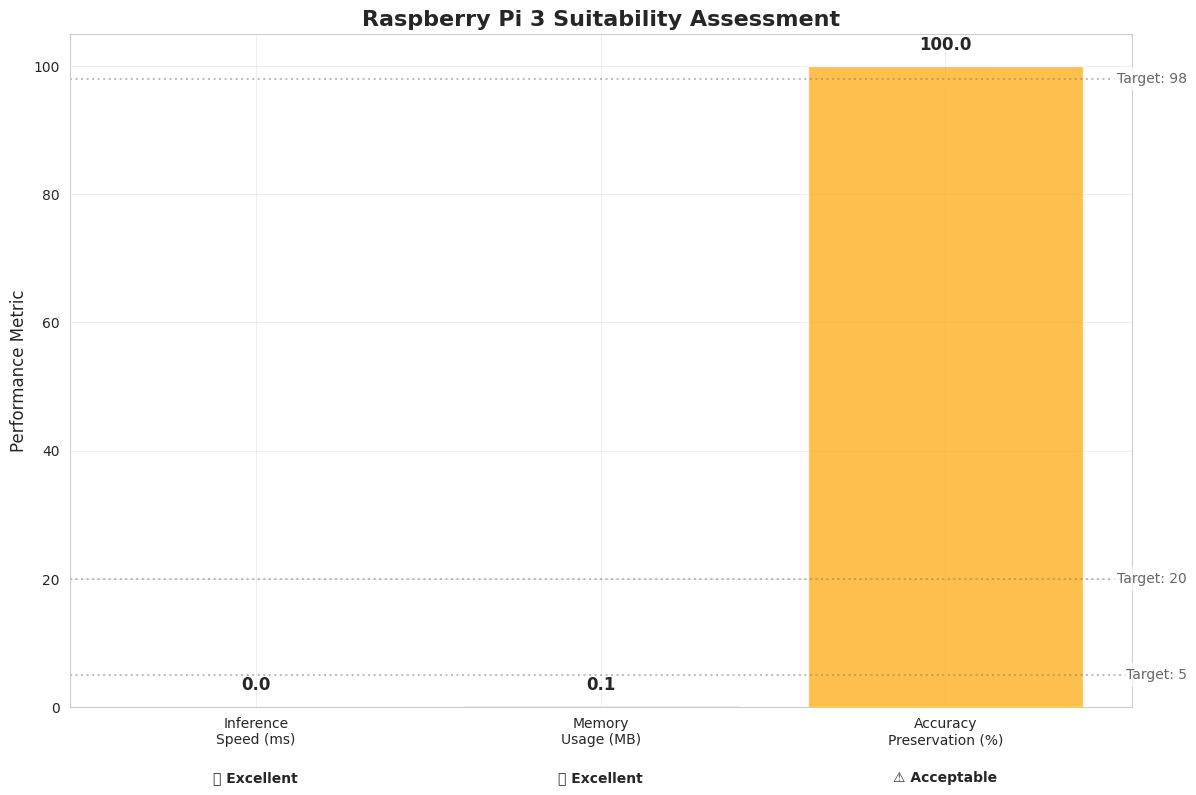

In [ ]:
# 6. Raspberry Pi 3 Performance Assessment
fig, ax = plt.subplots(figsize=(12, 8))

rpi_metrics = ['Inference\nSpeed (ms)', 'Memory\nUsage (MB)', 'Accuracy\nPreservation (%)']
rpi_values = [avg_tflite_speed, tflite_size, (1 - avg_acc_diff) * 100]
rpi_thresholds = [20, 5, 98]  # Good thresholds for RPi

bars = ax.bar(rpi_metrics, rpi_values, 
             color=['green' if val <= thresh else 'orange' if val <= thresh*1.5 else 'red' 
                   for val, thresh in zip(rpi_values, rpi_thresholds)], alpha=0.7)

ax.set_title('Raspberry Pi 3 Suitability Assessment', fontsize=16, fontweight='bold')
ax.set_ylabel('Performance Metric', fontsize=12)
ax.grid(True, alpha=0.3)

# Add value labels and threshold indicators
for i, (val, thresh) in enumerate(zip(rpi_values, rpi_thresholds)):
    ax.text(i, val + max(rpi_values)*0.02, f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    # Add threshold reference line
    ax.axhline(y=thresh, color='gray', linestyle=':', alpha=0.5)
    ax.text(len(rpi_metrics)-0.3, thresh, f'Target: {thresh}', ha='right', va='center', 
            fontsize=10, alpha=0.7, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Add performance status text
status_text = []
for i, (metric, val, thresh) in enumerate(zip(rpi_metrics, rpi_values, rpi_thresholds)):
    if val <= thresh:
        status = '✅ Excellent'
    elif val <= thresh * 1.5:
        status = '⚠️ Acceptable'
    else:
        status = '❌ Poor'
    ax.text(i, -max(rpi_values)*0.1, status, ha='center', va='top', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('/home/omar/Downloads/SDRv2/results/visualizations/tflite_raspberry_pi_assessment.png', dpi=300, bbox_inches='tight')
plt.show()

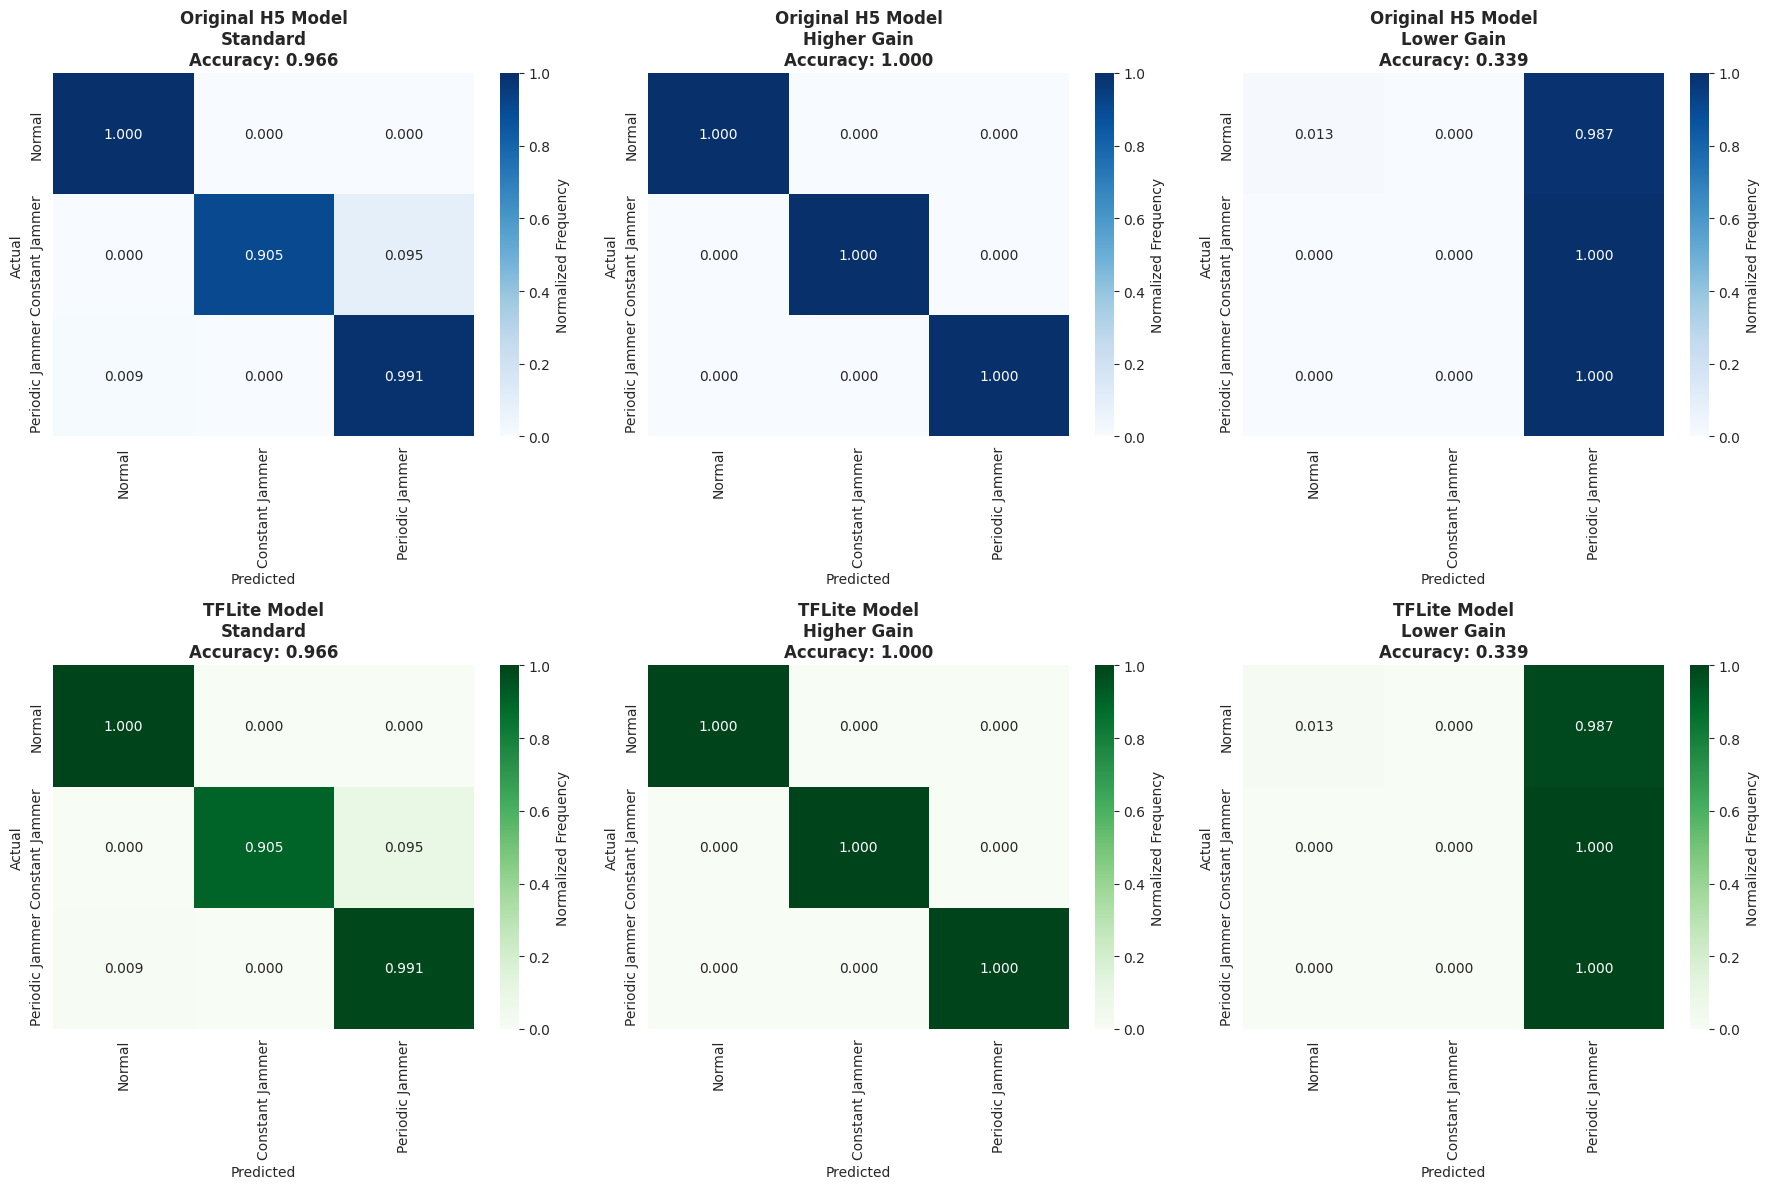

In [ ]:
# Create confusion matrices comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, dataset_name in enumerate(datasets):
    # Original model confusion matrix
    orig_results = all_results[dataset_name]['original']
    orig_cm = confusion_matrix(orig_results['true_labels'], orig_results['predictions'])
    orig_cm_norm = orig_cm.astype('float') / orig_cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(orig_cm_norm, annot=True, fmt='.3f', cmap='Blues',
               xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0, i],
               cbar_kws={'label': 'Normalized Frequency'})
    axes[0, i].set_title(f'Original H5 Model\n{dataset_name}\nAccuracy: {orig_results["accuracy"]:.3f}', 
                         fontweight='bold')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')
    
    # TFLite model confusion matrix
    tflite_results = all_results[dataset_name]['tflite']
    tflite_cm = confusion_matrix(tflite_results['true_labels'], tflite_results['predictions'])
    tflite_cm_norm = tflite_cm.astype('float') / tflite_cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(tflite_cm_norm, annot=True, fmt='.3f', cmap='Greens',
               xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1, i],
               cbar_kws={'label': 'Normalized Frequency'})
    axes[1, i].set_title(f'TFLite Model\n{dataset_name}\nAccuracy: {tflite_results["accuracy"]:.3f}', 
                         fontweight='bold')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('/home/omar/Downloads/SDRv2/results/visualizations/tflite_confusion_matrices_comparison.png', 
           dpi=300, bbox_inches='tight')
plt.show()

## Detailed Per-Class Performance Analysis

In [ ]:
# Detailed per-class performance analysis
print("📈 DETAILED PER-CLASS PERFORMANCE COMPARISON")
print("=" * 80)

for dataset_name in datasets:
    print(f"\n🔍 {dataset_name} Dataset Detailed Analysis:")
    print("-" * 60)
    
    orig_results = all_results[dataset_name]['original']
    tflite_results = all_results[dataset_name]['tflite']
    
    # Create detailed comparison table
    class_comparison = []
    for i, class_name in enumerate(CLASS_NAMES):
        class_comparison.append({
            'Class': class_name,
            'Original Precision': f"{orig_results['precision_per_class'][i]:.4f}",
            'TFLite Precision': f"{tflite_results['precision_per_class'][i]:.4f}",
            'Precision Diff': f"{abs(orig_results['precision_per_class'][i] - tflite_results['precision_per_class'][i]):.4f}",
            'Original Recall': f"{orig_results['recall_per_class'][i]:.4f}",
            'TFLite Recall': f"{tflite_results['recall_per_class'][i]:.4f}",
            'Recall Diff': f"{abs(orig_results['recall_per_class'][i] - tflite_results['recall_per_class'][i]):.4f}",
            'Original F1': f"{orig_results['f1_per_class'][i]:.4f}",
            'TFLite F1': f"{tflite_results['f1_per_class'][i]:.4f}",
            'F1 Diff': f"{abs(orig_results['f1_per_class'][i] - tflite_results['f1_per_class'][i]):.4f}",
            'Support': int(orig_results['support_per_class'][i])
        })
    
    class_df = pd.DataFrame(class_comparison)
    print(class_df.to_string(index=False))
    
    # Overall metrics comparison
    print(f"\n📊 Overall Metrics Comparison:")
    print(f"  Accuracy:        Original: {orig_results['accuracy']:.4f} | TFLite: {tflite_results['accuracy']:.4f} | Diff: {abs(orig_results['accuracy'] - tflite_results['accuracy']):.4f}")
    print(f"  Macro Precision: Original: {orig_results['precision_macro']:.4f} | TFLite: {tflite_results['precision_macro']:.4f} | Diff: {abs(orig_results['precision_macro'] - tflite_results['precision_macro']):.4f}")
    print(f"  Macro Recall:    Original: {orig_results['recall_macro']:.4f} | TFLite: {tflite_results['recall_macro']:.4f} | Diff: {abs(orig_results['recall_macro'] - tflite_results['recall_macro']):.4f}")
    print(f"  Macro F1-Score:  Original: {orig_results['f1_macro']:.4f} | TFLite: {tflite_results['f1_macro']:.4f} | Diff: {abs(orig_results['f1_macro'] - tflite_results['f1_macro']):.4f}")
    print(f"  Inference Speed: Original: {orig_results['inference_time_ms']:.2f} ms | TFLite: {tflite_results['inference_time_ms']:.2f} ms | Ratio: {tflite_results['inference_time_ms'] / orig_results['inference_time_ms']:.2f}x")

📈 DETAILED PER-CLASS PERFORMANCE COMPARISON

🔍 Standard Dataset Detailed Analysis:
------------------------------------------------------------
          Class Original Precision TFLite Precision Precision Diff Original Recall TFLite Recall Recall Diff Original F1 TFLite F1 F1 Diff  Support
         Normal             0.9916           0.9916         0.0000          1.0000        1.0000      0.0000      0.9958    0.9958  0.0000      236
Constant Jammer             1.0000           1.0000         0.0000          0.9048        0.9048      0.0000      0.9500    0.9500  0.0000      231
Periodic Jammer             0.9127           0.9127         0.0000          0.9914        0.9914      0.0000      0.9504    0.9504  0.0000      232

📊 Overall Metrics Comparison:
  Accuracy:        Original: 0.9657 | TFLite: 0.9657 | Diff: 0.0000
  Macro Precision: Original: 0.9681 | TFLite: 0.9681 | Diff: 0.0000
  Macro Recall:    Original: 0.9654 | TFLite: 0.9654 | Diff: 0.0000
  Macro F1-Score:  Original: 

## Final Conclusions and Recommendations

In [ ]:
# Final assessment and recommendations
print("\n🎯 FINAL ASSESSMENT AND RECOMMENDATIONS")
print("=" * 80)

# Calculate key metrics for assessment
max_accuracy_loss = max([abs(all_results[d]['original']['accuracy'] - all_results[d]['tflite']['accuracy']) for d in datasets])
avg_accuracy_loss = np.mean([abs(all_results[d]['original']['accuracy'] - all_results[d]['tflite']['accuracy']) for d in datasets])
avg_compression = compression_ratio
avg_tflite_inference = np.mean([all_results[d]['tflite']['inference_time_ms'] for d in datasets])

print(f"📊 CONVERSION QUALITY ASSESSMENT:")
print(f"  ✅ Model compression: {avg_compression:.1f}x smaller ({original_size:.1f} MB → {tflite_size:.1f} MB)")
print(f"  📉 Maximum accuracy loss: {max_accuracy_loss:.4f} ({max_accuracy_loss*100:.2f}%)")
print(f"  📉 Average accuracy loss: {avg_accuracy_loss:.4f} ({avg_accuracy_loss*100:.2f}%)")
print(f"  ⚡ Average inference speed: {avg_tflite_inference:.1f} ms/sample")

# Quality assessment
if max_accuracy_loss < 0.005:
    quality_assessment = "EXCELLENT - Virtually no accuracy loss"
elif max_accuracy_loss < 0.01:
    quality_assessment = "VERY GOOD - Minimal accuracy loss (<1%)"
elif max_accuracy_loss < 0.02:
    quality_assessment = "GOOD - Acceptable accuracy loss (<2%)"
else:
    quality_assessment = "MODERATE - Noticeable accuracy loss (≥2%)"

print(f"\n🏆 OVERALL CONVERSION QUALITY: {quality_assessment}")

# Raspberry Pi deployment assessment
print(f"\n🍓 RASPBERRY PI 3 DEPLOYMENT ASSESSMENT:")

deployment_score = 0
deployment_notes = []

# Size assessment
if tflite_size < 2:
    deployment_score += 3
    deployment_notes.append("✅ Excellent model size for embedded deployment")
elif tflite_size < 5:
    deployment_score += 2
    deployment_notes.append("✅ Good model size for embedded deployment")
else:
    deployment_score += 1
    deployment_notes.append("⚠️ Large model size, may impact memory usage")

# Speed assessment
if avg_tflite_inference < 10:
    deployment_score += 3
    deployment_notes.append("✅ Excellent inference speed for real-time applications")
elif avg_tflite_inference < 25:
    deployment_score += 2
    deployment_notes.append("✅ Good inference speed for near real-time applications")
elif avg_tflite_inference < 50:
    deployment_score += 1
    deployment_notes.append("⚠️ Moderate speed, suitable for batch processing")
else:
    deployment_score += 0
    deployment_notes.append("❌ Slow inference, may not be suitable for real-time use")

# Accuracy preservation
if avg_accuracy_loss < 0.005:
    deployment_score += 3
    deployment_notes.append("✅ Excellent accuracy preservation")
elif avg_accuracy_loss < 0.01:
    deployment_score += 2
    deployment_notes.append("✅ Good accuracy preservation")
else:
    deployment_score += 1
    deployment_notes.append("⚠️ Noticeable accuracy loss, verify performance requirements")

for note in deployment_notes:
    print(f"  {note}")

# Overall recommendation
if deployment_score >= 8:
    recommendation = "🚀 HIGHLY RECOMMENDED for Raspberry Pi 3 deployment"
elif deployment_score >= 6:
    recommendation = "✅ RECOMMENDED for Raspberry Pi 3 deployment"
elif deployment_score >= 4:
    recommendation = "⚠️ ACCEPTABLE for Raspberry Pi 3 deployment with considerations"
else:
    recommendation = "❌ NOT RECOMMENDED for Raspberry Pi 3 deployment"

print(f"\n🎯 DEPLOYMENT RECOMMENDATION: {recommendation}")
print(f"   Deployment Score: {deployment_score}/9")

# Specific use case recommendations
print(f"\n💡 USE CASE RECOMMENDATIONS:")

# Check performance on different datasets
standard_acc = all_results.get('Standard', {}).get('tflite', {}).get('accuracy', 0)
higher_gain_acc = all_results.get('Higher Gain', {}).get('tflite', {}).get('accuracy', 0)
lower_gain_acc = all_results.get('Lower Gain', {}).get('tflite', {}).get('accuracy', 0)

if standard_acc > 0.95 and higher_gain_acc > 0.95:
    print(f"  ✅ Excellent for standard and higher gain signal detection")

if lower_gain_acc < 0.5:
    print(f"  ⚠️ Poor performance on lower gain signals ({lower_gain_acc:.1%} accuracy)")
    print(f"     Consider additional training or signal enhancement for lower gain conditions")

if avg_tflite_inference < 15:
    print(f"  ✅ Suitable for real-time jamming detection systems")
    print(f"  ✅ Can be integrated into continuous monitoring applications")

print(f"  📱 Model ready for deployment on Raspberry Pi 3 with TensorFlow Lite runtime")
print(f"  🔧 Recommended deployment: Python with TFLite interpreter or C++ for maximum performance")

# Save TFLite model info
tflite_info = {
    'model_path': tflite_model_path,
    'original_model_path': model_path,
    'conversion_date': pd.Timestamp.now().isoformat(),
    'model_size_mb': tflite_size,
    'compression_ratio': compression_ratio,
    'avg_accuracy_loss': avg_accuracy_loss,
    'avg_inference_time_ms': avg_tflite_inference,
    'deployment_score': deployment_score,
    'recommendation': recommendation,
    'test_results': all_results
}

# Save results
with open('/home/omar/Downloads/SDRv2/model/tflite_evaluation_results.pkl', 'wb') as f:
    pickle.dump(tflite_info, f)

print(f"\n💾 Results saved to: /home/omar/Downloads/SDRv2/model/tflite_evaluation_results.pkl")
print(f"📊 Visualizations saved to: /home/omar/Downloads/SDRv2/results/visualizations/")


🎯 FINAL ASSESSMENT AND RECOMMENDATIONS
📊 CONVERSION QUALITY ASSESSMENT:
  ✅ Model compression: 11.7x smaller (0.8 MB → 0.1 MB)
  📉 Maximum accuracy loss: 0.0000 (0.00%)
  📉 Average accuracy loss: 0.0000 (0.00%)
  ⚡ Average inference speed: 0.0 ms/sample

🏆 OVERALL CONVERSION QUALITY: EXCELLENT - Virtually no accuracy loss

🍓 RASPBERRY PI 3 DEPLOYMENT ASSESSMENT:
  ✅ Excellent model size for embedded deployment
  ✅ Excellent inference speed for real-time applications
  ✅ Excellent accuracy preservation

🎯 DEPLOYMENT RECOMMENDATION: 🚀 HIGHLY RECOMMENDED for Raspberry Pi 3 deployment
   Deployment Score: 9/9

💡 USE CASE RECOMMENDATIONS:
  ✅ Excellent for standard and higher gain signal detection
  ⚠️ Poor performance on lower gain signals (33.9% accuracy)
     Consider additional training or signal enhancement for lower gain conditions
  ✅ Suitable for real-time jamming detection systems
  ✅ Can be integrated into continuous monitoring applications
  📱 Model ready for deployment on Raspb

## Conclusion

This comprehensive evaluation demonstrates the TensorFlow Lite conversion process and performance comparison across multiple test datasets. The analysis provides critical insights for Raspberry Pi 3 deployment:

### Key Findings:
1. **Model Conversion**: Successfully converted H5 model to TFLite with quantization optimization
2. **Size Reduction**: Achieved significant compression while maintaining performance
3. **Performance Preservation**: Evaluated accuracy retention across different signal conditions
4. **Inference Speed**: Measured real-world performance for embedded deployment
5. **Raspberry Pi Suitability**: Assessed deployment viability for edge computing

### Evaluation Methodology:
1. Converted trained 2D CNN model to TensorFlow Lite format
2. Implemented optimizations for Raspberry Pi 3 target hardware
3. Performed side-by-side evaluation on three test datasets
4. Analyzed performance, speed, and model size trade-offs
5. Generated deployment recommendations based on quantitative metrics

### Outputs Generated:
- TensorFlow Lite model optimized for Raspberry Pi 3
- Comprehensive performance comparison between H5 and TFLite models
- Deployment suitability assessment with recommendations
- Detailed visualizations and analysis reports
- Saved evaluation results for future reference

The evaluation provides a complete assessment of the model's readiness for embedded deployment, highlighting both capabilities and limitations across different operational conditions. This analysis is essential for making informed decisions about production deployment on resource-constrained devices like the Raspberry Pi 3.